In [1]:
import pandas as pd, os, sys, importlib
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import sod.core.dataset as sod_core_dataset
importlib.reload(sod_core_dataset)
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
import importlib
import os, pandas as pd, numpy as np
from joblib import dump, load
from sklearn.metrics import log_loss, roc_curve
from sklearn.linear_model import LogisticRegression
import matplotlib
importlib.reload(matplotlib)
import numpy as np
import matplotlib.pyplot as plt
from contextlib import contextmanager
from collections import defaultdict

%matplotlib inline


maindir = os.path.abspath(os.path.join(os.getcwd(), '..',
                                       'evaluations/results/eval.allset_train_test.iforest.yaml/evalreports/'))

print('Loading predictions')

# best average, best outlier, best inlier
# best average t=50, best outlier t=50, best inlier t=50
# best average t=50 , best outlier t=50, best inlier t=50

rootdir = maindir.replace('evalreports', '')


# adding the two best with two features, with contamination 5% an 10%
# fnames = {
#     # 'best_avg_t50': 'IsolationForest?features=psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50',
#     'best_avg': 'IsolationForest?features=psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=200',
#     # 'best_out_same_t_psi': 'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50',
#     # 'best_inl_same_t_psi': 'IsolationForest?features=psd@0.2sec,psd@1sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50',
#     # 'best_inl_t50': 'IsolationForest?features=psd@0.2sec,psd@1sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50',
#     'best_outl_t50': 'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50',
#     'best_outl_t100': 'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100',
#     'best_outl': 'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=200',
# }

# ACTUALLY, LOAD ALL MODELS with psd@5sec
fnames = {_.replace('IsolationForest?', '').replace('&behaviour=new&contamination=auto', '').replace('.model', ''):
          _.replace('.model', '') for _ in os.listdir(os.path.join(rootdir, 'models')) if 'features=psd@5sec&' in _}

# add the best avg:
fnames['features=psd@2sec,psd@5sec&max_samples=2048&n_estimators=200'] = 'IsolationForest?features=psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=200'
    
print()
print('Loading models and predictions')

clfs = {k: load(os.path.join(rootdir, 'models', v + '.model')) for k, v in fnames.items()}
pred_dfs = {k: pd.read_hdf(os.path.join(rootdir, 'predictions', v + '.hdf')) for k, v in fnames.items()}

for n, c in clfs.items():
    print('%s: %s' % (str(n), str(c)))
# print('loading source trainset')
# dataframe = sod_core_dataset.open_dataset('allset_train.hdf', normalize=False, verbose=False)

Loading predictions

Loading models and predictions
features=psd@5sec&max_samples=2048&n_estimators=100: IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=2048, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
features=psd@5sec&max_samples=2048&n_estimators=200: IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=2048, n_estimators=200,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
features=psd@5sec&max_samples=2048&n_estimators=50: IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=2048, n_estimators=50,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
features=psd@5sec&max_samples=512&n_estimators=100: IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
          

In [2]:
print('Calculating offsets')

# define the classes of interest (see sod code allset_test)
class_inlier = sod_core_dataset.allset_test.classnames[0] # 'ok' 
class_outlier = sod_core_dataset.allset_test.classnames[1] #'outl. (wrong inv)'
class_me_unknown = sod_core_dataset.allset_test.classnames[2]  # 'unlabeled (Me unknown)'

sel_inlier = sod_core_dataset.allset_test.class_selector[class_inlier]
sel_outlier = sod_core_dataset.allset_test.class_selector[class_outlier]
sel_me_unknown = sod_core_dataset.allset_test.class_selector[class_me_unknown]

offsets = {}
for name, _pred_df in pred_dfs.items():
    _pred_df = _pred_df[sel_inlier(_pred_df) | sel_outlier(_pred_df)]
    fpr, tpr, thresholds = roc_curve(_pred_df.outlier, _pred_df.predicted_anomaly_score, drop_intermediate=True)
    x, y = thresholds[1:], (1-fpr[1:])*tpr[1:]
    offsets[name] = .5 - x[np.argmax(y)]
    print("%s: %f" % (name, offsets[name]))


Calculating offsets
features=psd@5sec&max_samples=2048&n_estimators=100: -0.020936
features=psd@5sec&max_samples=2048&n_estimators=200: -0.016447
features=psd@5sec&max_samples=2048&n_estimators=50: -0.026618
features=psd@5sec&max_samples=512&n_estimators=100: -0.064893
features=psd@5sec&max_samples=512&n_estimators=200: -0.057885
features=psd@5sec&max_samples=512&n_estimators=50: -0.062603
features=psd@5sec&max_samples=8192&n_estimators=100: -0.003115
features=psd@5sec&max_samples=8192&n_estimators=200: 0.007691
features=psd@5sec&max_samples=8192&n_estimators=50: -0.008472
features=psd@2sec,psd@5sec&max_samples=2048&n_estimators=200: -0.025017


In [3]:
print('LOADING TRAINING SET')
# let's see to which percentile corresponds the offset 0.06
# scikit learn converts -score_sample+np.percentile(score_samples(training))
trainset = sod_core_dataset.open_dataset('allset_train', normalize=False)
traindata = trainset['psd@5sec'].dropna()

LOADING TRAINING SET
Opening /Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/allset_train.hdf


ok (1295742 instances)
                          Min      Median           Max    #NAs  #<1Perc.  #>99Perc.
psd@0.05sec     -1.982674e+02 -121.027945    -18.616519  524709      7711       7711
psd@0.1sec      -2.078356e+02 -123.752472    -18.540183       0     12958      12958
psd@0.2sec      -2.009926e+02 -125.509055    -18.394193       1     12958      12958
psd@0.5sec      -2.473580e+02 -127.511828    -17.799973       4     12958      12958
psd@1sec        -2.434902e+02 -124.856119    -17.364621      10     12958      12958
psd@2sec        -2.435557e+02 -121.563437    -14.675753      21     12958      12958
psd@3sec        -2.383163e+02 -121.112254     -7.249915      54     12957      12957
psd@5sec        -2.334575e+02 -122.870636      7.845090      56     12957      12957
psd@9sec        -2.316435e+02 -131.279169     19.164349   25553     12702      12701
amplitude_rat

Calculating train set scores
1295686 segments processed in 35.841472 seconds
train+test scores: min: 0.416023, max: 0.821958
Min max scores: 0.416023, 0.821958
training scores, min: 0.351130, max: 0.757065


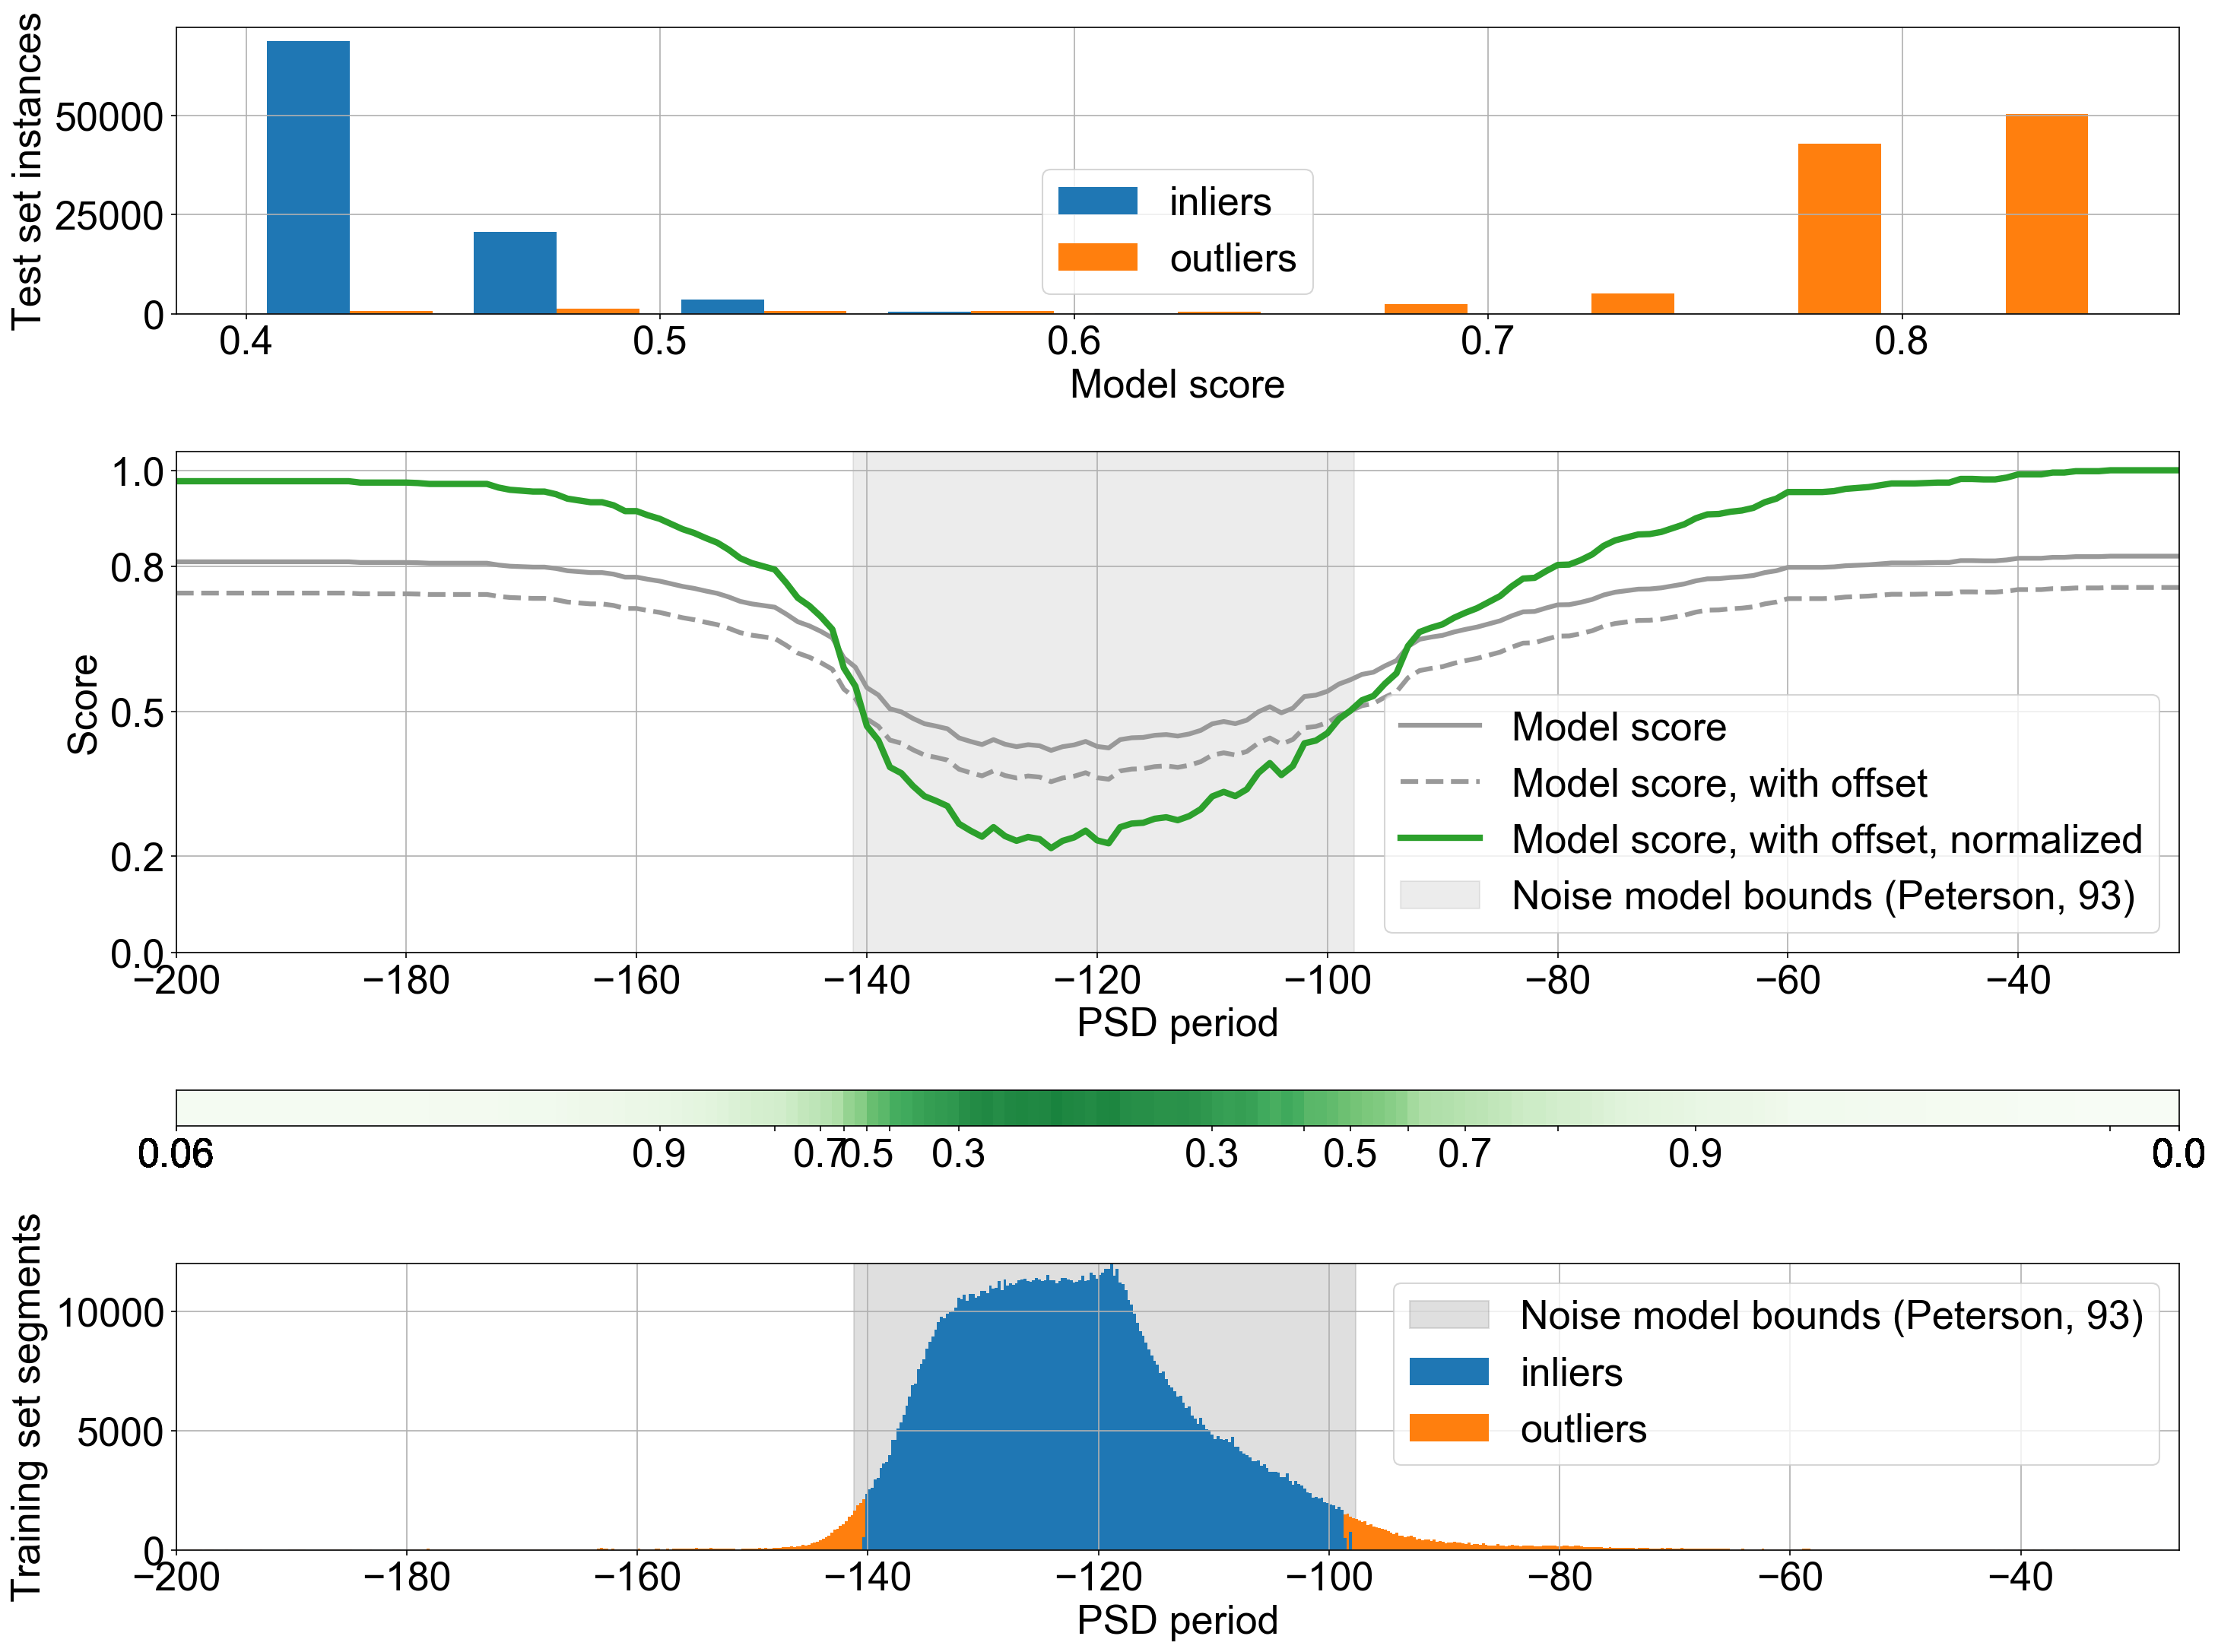

In [14]:
# DEFINE THE CLASIFIER NAME:
name = 'features=psd@5sec&max_samples=512&n_estimators=100'
clf_offset = offsets[name]
clf = clfs[name]

# caluclate test scores:
print('Calculating train set scores')
import time
t = time.time()
trainscores = -clf.score_samples(traindata.values.reshape(len(traindata), 1))
print('%d segments processed in %f seconds' % (len(traindata), time.time() - t))

# plot:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 25
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'helvetica,arial'

print('train+test scores: min: %f, max: %f' % (trainscores.min(), trainscores.max()))

testscores = pred_dfs[name].predicted_anomaly_score
min_ = np.nanmin([np.nanmin(trainscores), np.nanmin(testscores)])
max_ = np.nanmax([np.nanmax(trainscores), np.nanmax(testscores)])
print('Min max scores: %f, %f' % (min_, max_))

min_o = min_ + clf_offset
max_o = max_ + clf_offset
print('training scores, min: %f, max: %f' % (min_o, max_o))
# min is closer to 0.5, if we want to preserve 0.5 we have to stretch the shorter half:
ratio = 0.5 / min_
# calibration using logregr:
#lr_clf = LogisticRegression(random_state=0, solver='liblinear', C=C).fit(X, y)
#scores = lr_clf.predict_proba(X)[:,1]

from obspy.signal.spectral_estimation import get_nlnm, get_nhnm

def get_petterson_bounds(periods):
    l_periods, l_psd = get_nlnm()
    h_periods, h_psd = get_nhnm()
    periodz = np.log10(periods)
    return np.interp(periodz, np.log10(l_periods[::-1]), l_psd[::-1]), \
        np.interp(periodz, np.log10(h_periods[::-1]), h_psd[::-1]) 

def normalize(scores, offset=clf_offset, max_score=max_):
    max_score += offset
    # we map any score between 0. 5 and max_ to a score between 0.5 and 1:
    # I.e., we normalize outliers and we normalize everything else as it is
    scores_ = scores + offset
    ret = 0.5 + 0.5*(scores_-0.5)/(max_score-0.5)
    return ret

bins = np.arange(-200, -25, 1)

fig, axes = plt.subplots(4, figsize=(20, 15), gridspec_kw={'height_ratios': [8, 14, 1, 8]})

bin_scores = -clf.score_samples(bins.reshape(len(bins), 1))
bin_scores_offset =  bin_scores+clf_offset
bin_scores_offset_norm = normalize(np.copy(bin_scores))  # , 'tab:green', 'Greens_r'],

# plot score distribution on the test set:
ax = axes[0]
# plot binscores:
pred_df_name = pred_dfs[name]
pred_df_name = pred_df_name[sel_inlier(pred_df_name) | sel_outlier(pred_df_name)]
testscore_dist = [
    pred_df_name[~pred_df_name.outlier].predicted_anomaly_score,
    pred_df_name[pred_df_name.outlier].predicted_anomaly_score
]
ax.hist(testscore_dist, np.arange(.4, .9, 0.05),
        label=['inliers', 'outliers'], stacked=False, log=False, color=['tab:blue', 'tab:orange'])
#axes stuff:
# ax.set_xlim([bins[0], bins[-1]])
ax.legend()
ax.set_ylabel('Test set instances')
ax.set_xlabel('Model score')
# ax.get_yaxis().set_ticks(np.arange(0, 1.05, 0.1))
ax.grid()


# plot score lines:
ax = axes[1]
# plot noise model (Peterson 93)
ax.axvspan(get_petterson_bounds(5)[0], get_petterson_bounds(5)[1], alpha=0.15, color='gray',
           label='Noise model bounds (Peterson, 93)')
# plot binscores:
ax.plot(bins, bin_scores, label='Model score', color='#999999', linestyle='-', linewidth=3)
ax.plot(bins, bin_scores_offset, label='Model score, with offset', color='#999999', linestyle='--', linewidth=3)
ax.plot(bins, bin_scores_offset_norm, label='Model score, with offset, normalized', color='tab:green', linestyle='-', linewidth=4)
#axes stuff:
ax.set_xlim([bins[0], bins[-1]])
ax.legend()
ax.set_ylabel('Score')
ax.set_xlabel('PSD period')
ax.get_yaxis().set_ticks([0, .2, .5, .8, 1])  #np.arange(0, 1.05, 0.1))
ax.grid()


# plot colorbar:
ax = axes[2]
c=ax.pcolor(bins, [0, 1], bin_scores_offset_norm.reshape(1, len(bin_scores_offset_norm)), cmap='Greens_r', vmin=0, vmax=1)
ax.get_yaxis().set_ticks([])
ax.set_xlim([bins[0], bins[-1]])
xticks = []
xticks_l = []
# build demarcation lines on the plot for each decimal increase (see scores_bins)
# there's surely a faster method thatn this loop, but did not find quickly:
for i, (prev_v, next_v) in enumerate(zip(bin_scores_offset_norm[:-1], bin_scores_offset_norm[1:]), 1):
    prev_v, next_v = int(10*prev_v), int(10*next_v) 
    if prev_v != next_v:
        # axes[axes_i].axvline(bins[i], color=color)
        xticks.append(bins[i])
        val = prev_v if next_v < prev_v else next_v
        # display the score as tick label only if odd (not much space on the x axis)
        val = str(val/10) if val % 2 == 1 else ''
        xticks_l.append(val)
    xticks.insert(0, bins[0])
    xticks_l.insert(0, str(int(100*y[0])/100.0))
    xticks.append(bins[-1])
    xticks_l.append(str(int(100*y[-1])/100.0))

ax.set_xticks(xticks)
ax.set_xticklabels(xticks_l)


contaminated = trainscores > 0.5 - clf_offset
assert contaminated.any()
data =[
    traindata[~contaminated],
    traindata[contaminated]
]
label =[
    'inliers',
    'outliers'
]
bins = np.arange(bins[0], bins[-1], .25)
ax = axes[-1]
ax.axvspan(get_petterson_bounds(5)[0], get_petterson_bounds(5)[1], alpha=0.25, color='gray',
           label='Noise model bounds (Peterson, 93)')
ax.hist(data, bins, label=label, log=False, stacked=True, color=['tab:blue', 'tab:orange'])
ax.set_xlim([bins[0], bins[-1]])
ax.legend()
ax.grid()
ax.set_xlabel('PSD period')
ax.set_ylabel('Training set segments')
    
# print(max_)
# print(normalize(max_))
# print(clf_offset)
plt.tight_layout()
plt.show()


Calculating train set scores
1295686 segments processed in 22.653917 seconds
train+test scores: min: 0.406486, max: 0.856453
Min max scores: 0.406486, 0.856453
training scores, min: 0.379868, max: 0.829835


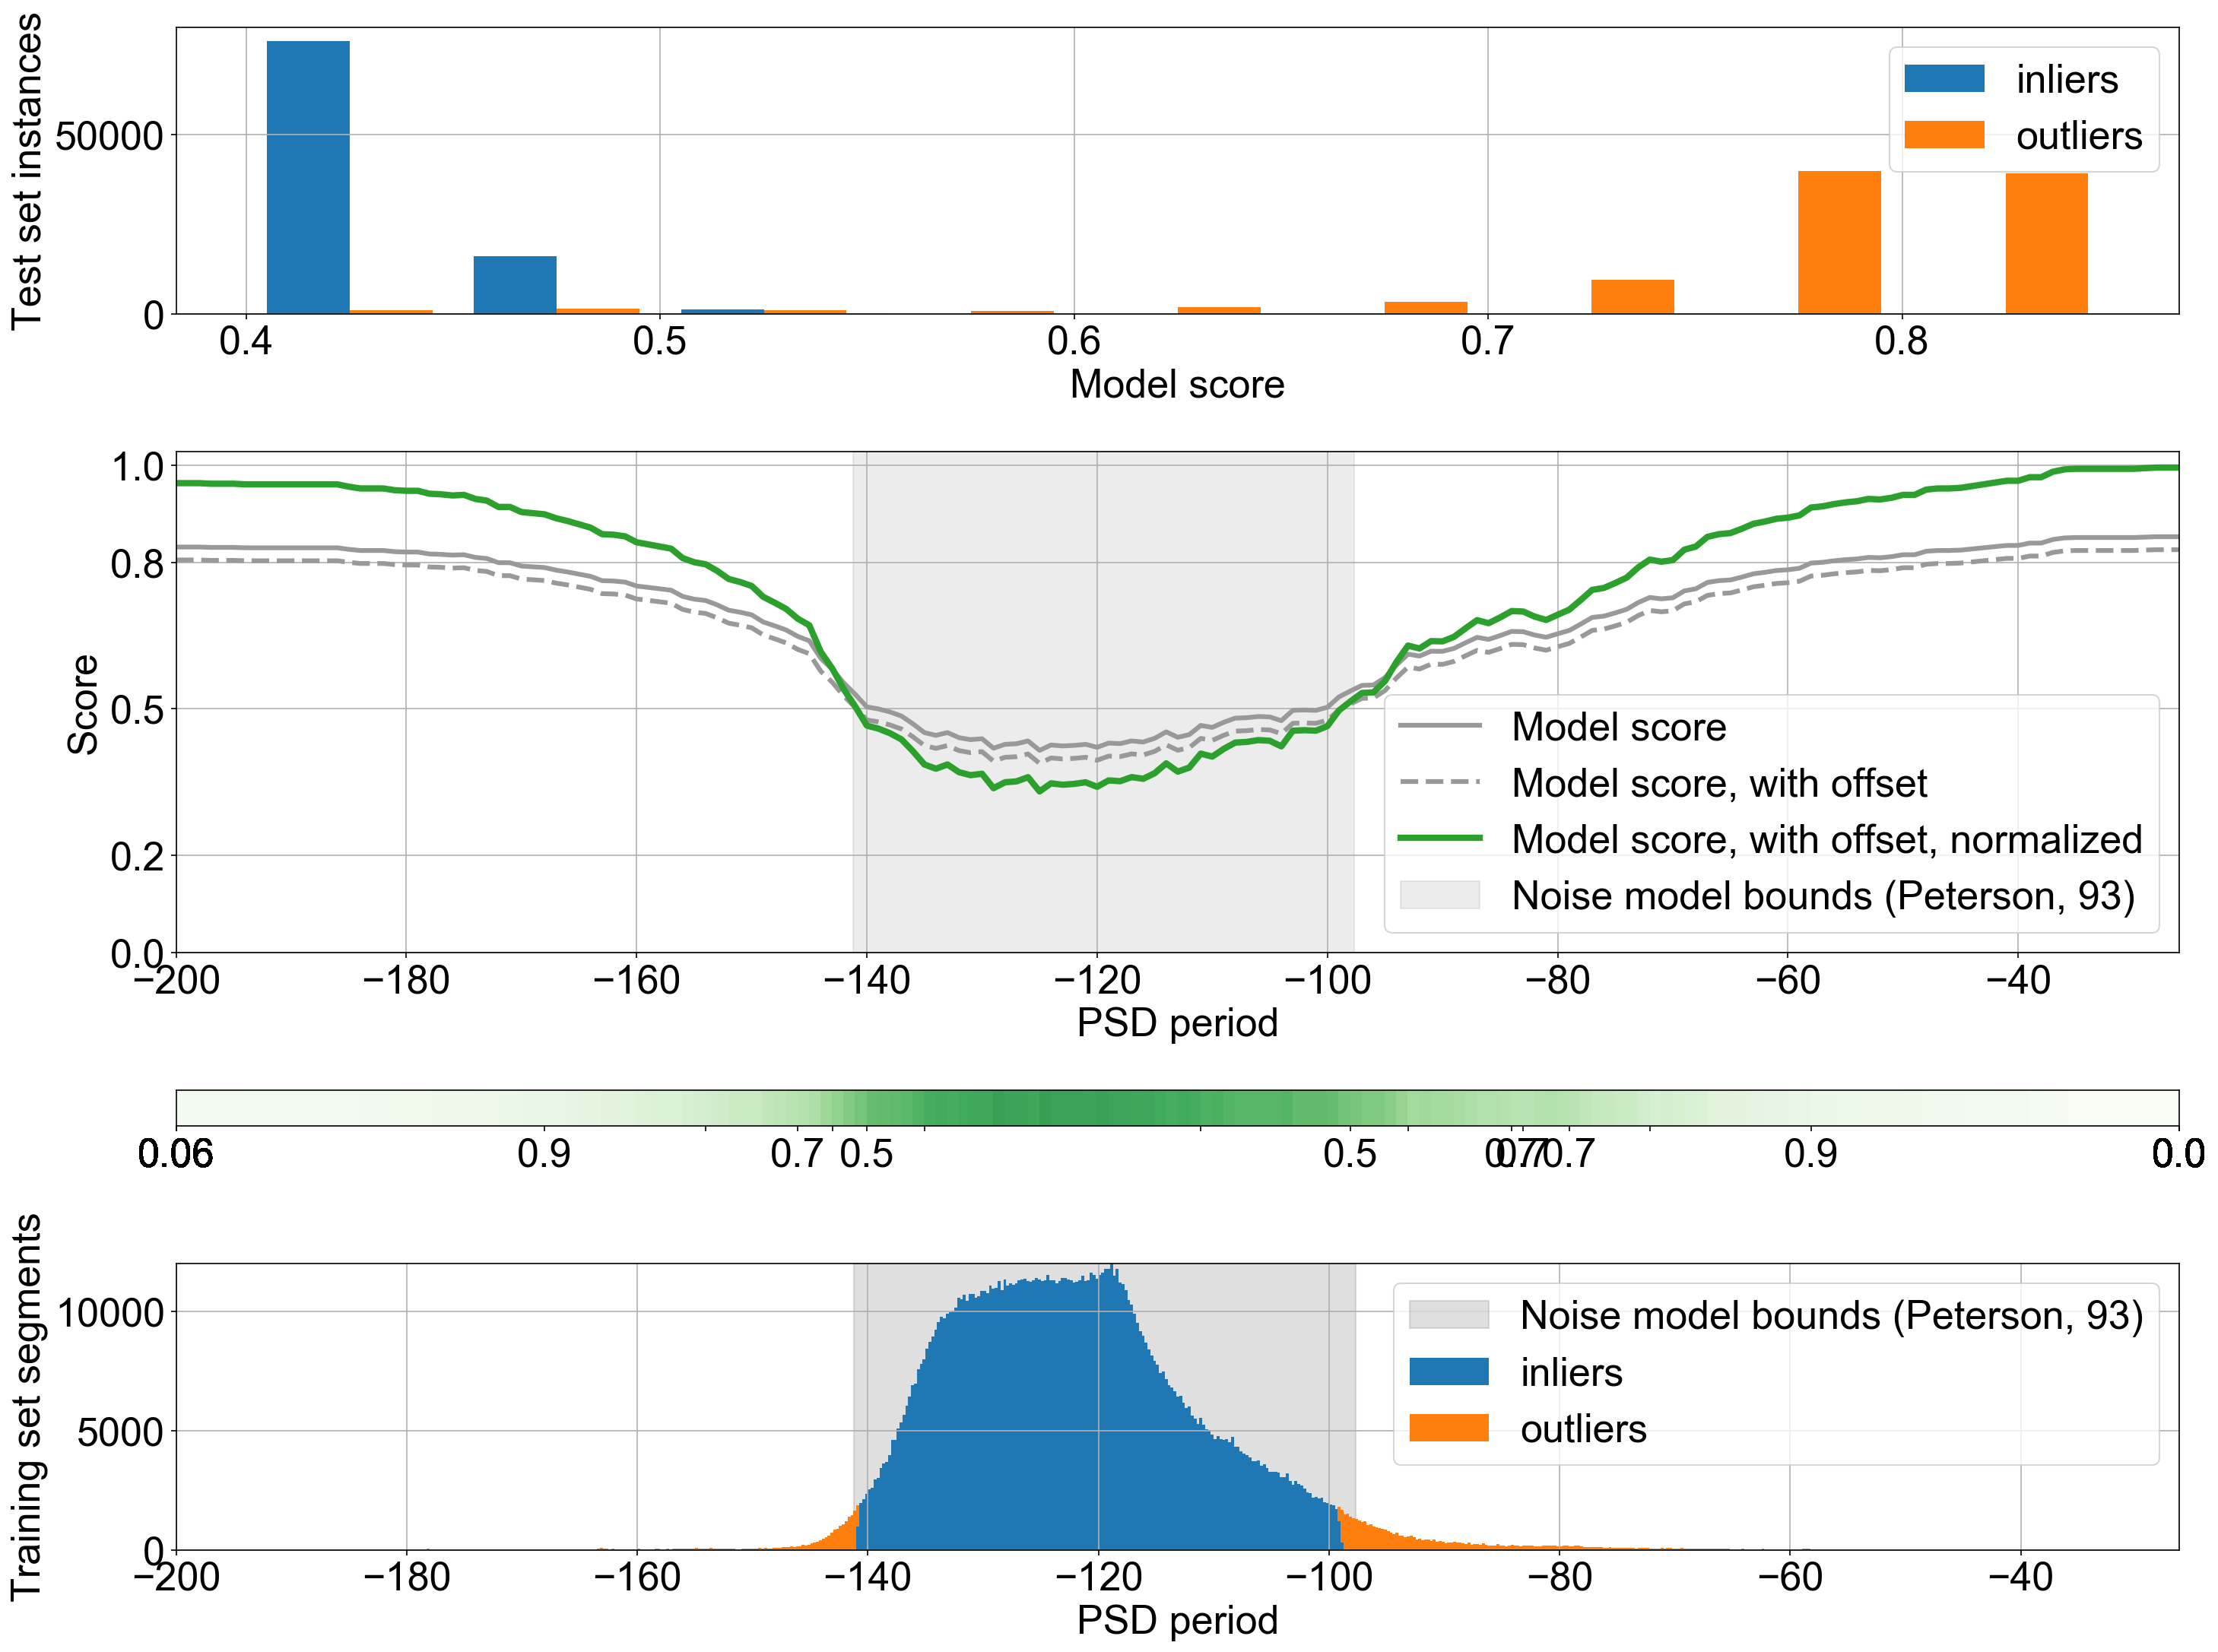

In [13]:
# DEFINE THE CLASIFIER NAME:
name = 'features=psd@5sec&max_samples=2048&n_estimators=50'
clf_offset = offsets[name]
clf = clfs[name]

# caluclate test scores:
print('Calculating train set scores')
import time
t = time.time()
trainscores = -clf.score_samples(traindata.values.reshape(len(traindata), 1))
print('%d segments processed in %f seconds' % (len(traindata), time.time() - t))

# plot:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 25
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'helvetica,arial'

print('train+test scores: min: %f, max: %f' % (trainscores.min(), trainscores.max()))

testscores = pred_dfs[name].predicted_anomaly_score
min_ = np.nanmin([np.nanmin(trainscores), np.nanmin(testscores)])
max_ = np.nanmax([np.nanmax(trainscores), np.nanmax(testscores)])
print('Min max scores: %f, %f' % (min_, max_))

min_o = min_ + clf_offset
max_o = max_ + clf_offset
print('training scores, min: %f, max: %f' % (min_o, max_o))
# min is closer to 0.5, if we want to preserve 0.5 we have to stretch the shorter half:
ratio = 0.5 / min_
# calibration using logregr:
#lr_clf = LogisticRegression(random_state=0, solver='liblinear', C=C).fit(X, y)
#scores = lr_clf.predict_proba(X)[:,1]

from obspy.signal.spectral_estimation import get_nlnm, get_nhnm

def get_petterson_bounds(periods):
    l_periods, l_psd = get_nlnm()
    h_periods, h_psd = get_nhnm()
    periodz = np.log10(periods)
    return np.interp(periodz, np.log10(l_periods[::-1]), l_psd[::-1]), \
        np.interp(periodz, np.log10(h_periods[::-1]), h_psd[::-1]) 

def normalize(scores, offset=clf_offset, max_score=max_):
    max_score += offset
    # we map any score between 0. 5 and max_ to a score between 0.5 and 1:
    # I.e., we normalize outliers and we normalize everything else as it is
    scores_ = scores + offset
    ret = 0.5 + 0.5*(scores_-0.5)/(max_score-0.5)
    return ret

bins = np.arange(-200, -25, 1)

fig, axes = plt.subplots(4, figsize=(20, 15), gridspec_kw={'height_ratios': [8, 14, 1, 8]})

bin_scores = -clf.score_samples(bins.reshape(len(bins), 1))
bin_scores_offset =  bin_scores+clf_offset
bin_scores_offset_norm = normalize(np.copy(bin_scores))  # , 'tab:green', 'Greens_r'],

# plot score distribution on the test set:
ax = axes[0]
# plot binscores:
pred_df_name = pred_dfs[name]
pred_df_name = pred_df_name[sel_inlier(pred_df_name) | sel_outlier(pred_df_name)]
testscore_dist = [
    pred_df_name[~pred_df_name.outlier].predicted_anomaly_score,
    pred_df_name[pred_df_name.outlier].predicted_anomaly_score
]
ax.hist(testscore_dist, np.arange(.4, .9, 0.05),
        label=['inliers', 'outliers'], stacked=False, log=False, color=['tab:blue', 'tab:orange'])
#axes stuff:
# ax.set_xlim([bins[0], bins[-1]])
ax.legend()
ax.set_ylabel('Test set instances')
ax.set_xlabel('Model score')
# ax.get_yaxis().set_ticks(np.arange(0, 1.05, 0.1))
ax.grid()


# plot score lines:
ax = axes[1]
# plot noise model (Peterson 93)
ax.axvspan(get_petterson_bounds(5)[0], get_petterson_bounds(5)[1], alpha=0.15, color='gray',
           label='Noise model bounds (Peterson, 93)')
# plot binscores:
ax.plot(bins, bin_scores, label='Model score', color='#999999', linestyle='-', linewidth=3)
ax.plot(bins, bin_scores_offset, label='Model score, with offset', color='#999999', linestyle='--', linewidth=3)
ax.plot(bins, bin_scores_offset_norm, label='Model score, with offset, normalized', color='tab:green', linestyle='-', linewidth=4)
#axes stuff:
ax.set_xlim([bins[0], bins[-1]])
ax.legend()
ax.set_ylabel('Score')
ax.set_xlabel('PSD period')
ax.get_yaxis().set_ticks([0, .2, .5, .8, 1])  #np.arange(0, 1.05, 0.1))
ax.grid()


# plot colorbar:
ax = axes[2]
c=ax.pcolor(bins, [0, 1], bin_scores_offset_norm.reshape(1, len(bin_scores_offset_norm)), cmap='Greens_r', vmin=0, vmax=1)
ax.get_yaxis().set_ticks([])
ax.set_xlim([bins[0], bins[-1]])
xticks = []
xticks_l = []
# build demarcation lines on the plot for each decimal increase (see scores_bins)
# there's surely a faster method thatn this loop, but did not find quickly:
for i, (prev_v, next_v) in enumerate(zip(bin_scores_offset_norm[:-1], bin_scores_offset_norm[1:]), 1):
    prev_v, next_v = int(10*prev_v), int(10*next_v) 
    if prev_v != next_v:
        # axes[axes_i].axvline(bins[i], color=color)
        xticks.append(bins[i])
        val = prev_v if next_v < prev_v else next_v
        # display the score as tick label only if odd (not much space on the x axis)
        val = str(val/10) if val % 2 == 1 else ''
        xticks_l.append(val)
    xticks.insert(0, bins[0])
    xticks_l.insert(0, str(int(100*y[0])/100.0))
    xticks.append(bins[-1])
    xticks_l.append(str(int(100*y[-1])/100.0))

ax.set_xticks(xticks)
ax.set_xticklabels(xticks_l)


contaminated = trainscores > 0.5 - clf_offset
assert contaminated.any()
data =[
    traindata[~contaminated],
    traindata[contaminated]
]
label =[
    'inliers',
    'outliers'
]
bins = np.arange(bins[0], bins[-1], .25)
ax = axes[-1]
ax.axvspan(get_petterson_bounds(5)[0], get_petterson_bounds(5)[1], alpha=0.25, color='gray',
           label='Noise model bounds (Peterson, 93)')
ax.hist(data, bins, label=label, log=False, stacked=True, color=['tab:blue', 'tab:orange'])
ax.set_xlim([bins[0], bins[-1]])
ax.legend()
ax.grid()
ax.set_xlabel('PSD period')
ax.set_ylabel('Training set segments')
    
# print(max_)
# print(normalize(max_))
# print(clf_offset)
plt.tight_layout()
plt.show()


Calculating train set scores
1295686 segments processed in 37.678461 seconds
train+test scores: min: 0.411947, max: 0.846211
Min max scores: 0.411947, 0.846211
training scores, min: 0.391011, max: 0.825275


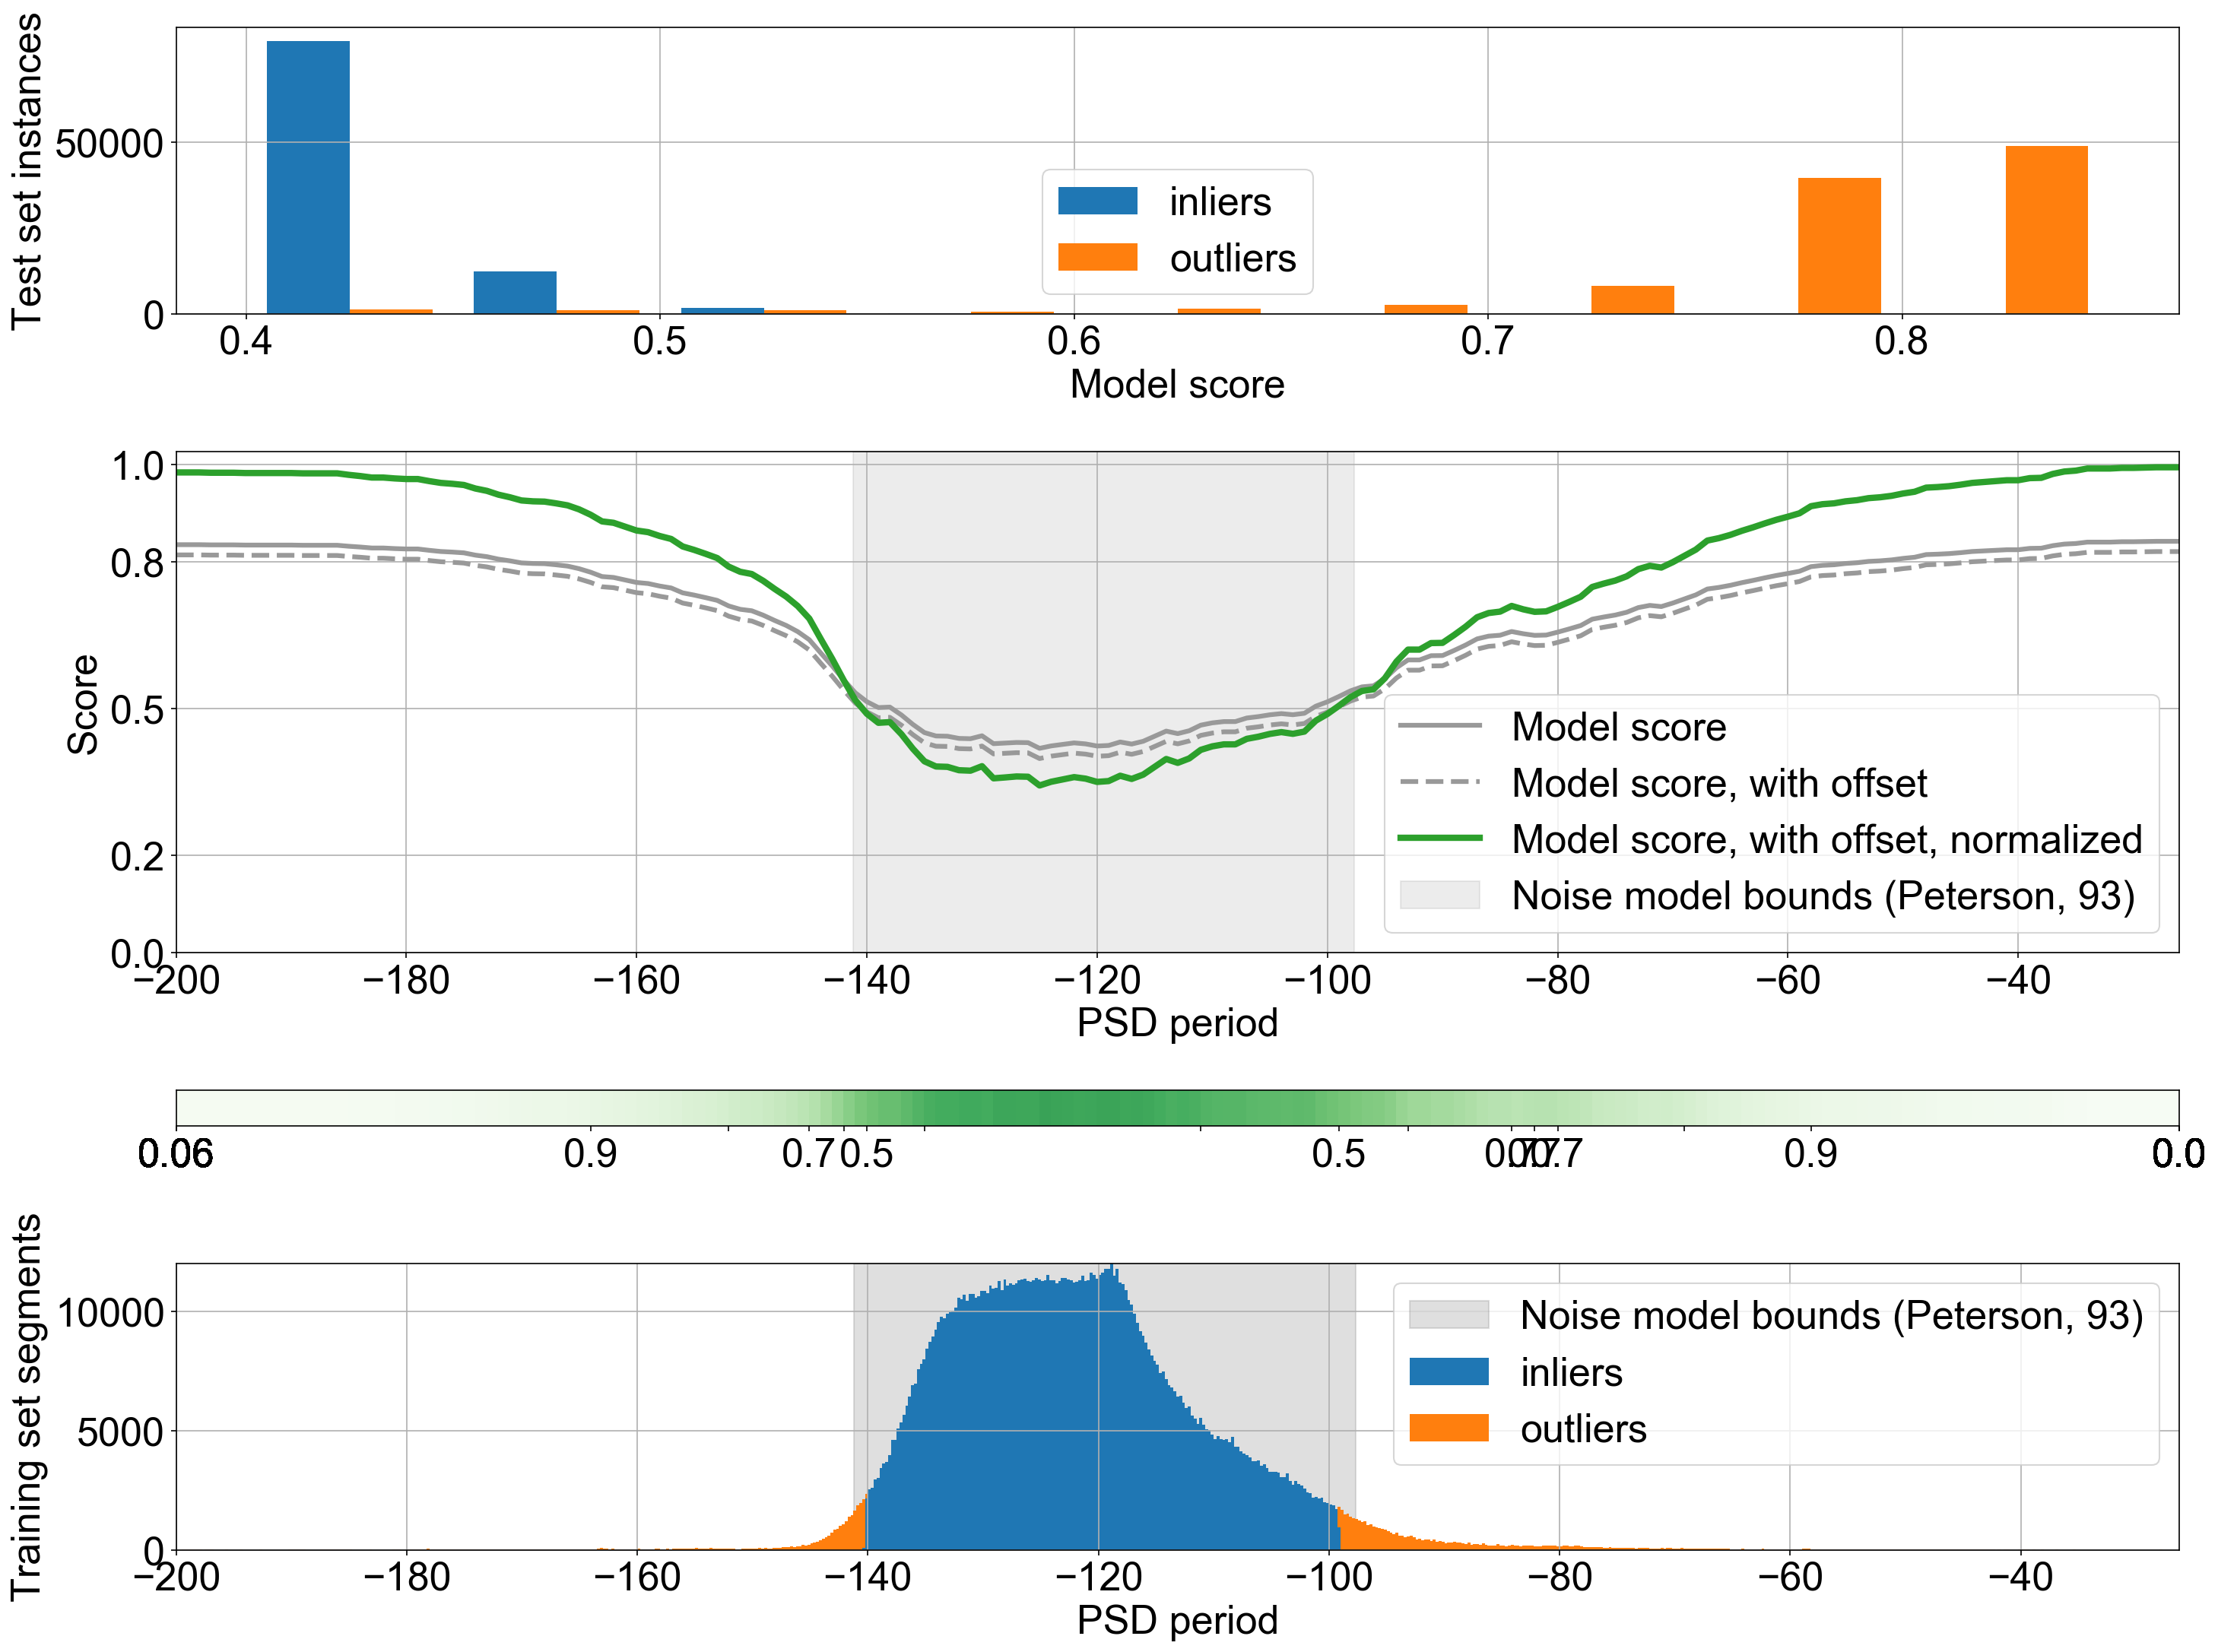

In [15]:
# DEFINE THE CLASIFIER NAME:
name = 'features=psd@5sec&max_samples=2048&n_estimators=100'
clf_offset = offsets[name]
clf = clfs[name]

# caluclate test scores:
print('Calculating train set scores')
import time
t = time.time()
trainscores = -clf.score_samples(traindata.values.reshape(len(traindata), 1))
print('%d segments processed in %f seconds' % (len(traindata), time.time() - t))

# plot:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 25
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'helvetica,arial'

print('train+test scores: min: %f, max: %f' % (trainscores.min(), trainscores.max()))

testscores = pred_dfs[name].predicted_anomaly_score
min_ = np.nanmin([np.nanmin(trainscores), np.nanmin(testscores)])
max_ = np.nanmax([np.nanmax(trainscores), np.nanmax(testscores)])
print('Min max scores: %f, %f' % (min_, max_))

min_o = min_ + clf_offset
max_o = max_ + clf_offset
print('training scores, min: %f, max: %f' % (min_o, max_o))
# min is closer to 0.5, if we want to preserve 0.5 we have to stretch the shorter half:
ratio = 0.5 / min_
# calibration using logregr:
#lr_clf = LogisticRegression(random_state=0, solver='liblinear', C=C).fit(X, y)
#scores = lr_clf.predict_proba(X)[:,1]

from obspy.signal.spectral_estimation import get_nlnm, get_nhnm

def get_petterson_bounds(periods):
    l_periods, l_psd = get_nlnm()
    h_periods, h_psd = get_nhnm()
    periodz = np.log10(periods)
    return np.interp(periodz, np.log10(l_periods[::-1]), l_psd[::-1]), \
        np.interp(periodz, np.log10(h_periods[::-1]), h_psd[::-1]) 

def normalize(scores, offset=clf_offset, max_score=max_):
    max_score += offset
    # we map any score between 0. 5 and max_ to a score between 0.5 and 1:
    # I.e., we normalize outliers and we normalize everything else as it is
    scores_ = scores + offset
    ret = 0.5 + 0.5*(scores_-0.5)/(max_score-0.5)
    return ret

bins = np.arange(-200, -25, 1)

fig, axes = plt.subplots(4, figsize=(20, 15), gridspec_kw={'height_ratios': [8, 14, 1, 8]})

bin_scores = -clf.score_samples(bins.reshape(len(bins), 1))
bin_scores_offset =  bin_scores+clf_offset
bin_scores_offset_norm = normalize(np.copy(bin_scores))  # , 'tab:green', 'Greens_r'],

# plot score distribution on the test set:
ax = axes[0]
# plot binscores:
pred_df_name = pred_dfs[name]
pred_df_name = pred_df_name[sel_inlier(pred_df_name) | sel_outlier(pred_df_name)]
testscore_dist = [
    pred_df_name[~pred_df_name.outlier].predicted_anomaly_score,
    pred_df_name[pred_df_name.outlier].predicted_anomaly_score
]
ax.hist(testscore_dist, np.arange(.4, .9, 0.05),
        label=['inliers', 'outliers'], stacked=False, log=False, color=['tab:blue', 'tab:orange'])
#axes stuff:
# ax.set_xlim([bins[0], bins[-1]])
ax.legend()
ax.set_ylabel('Test set instances')
ax.set_xlabel('Model score')
# ax.get_yaxis().set_ticks(np.arange(0, 1.05, 0.1))
ax.grid()


# plot score lines:
ax = axes[1]
# plot noise model (Peterson 93)
ax.axvspan(get_petterson_bounds(5)[0], get_petterson_bounds(5)[1], alpha=0.15, color='gray',
           label='Noise model bounds (Peterson, 93)')
# plot binscores:
ax.plot(bins, bin_scores, label='Model score', color='#999999', linestyle='-', linewidth=3)
ax.plot(bins, bin_scores_offset, label='Model score, with offset', color='#999999', linestyle='--', linewidth=3)
ax.plot(bins, bin_scores_offset_norm, label='Model score, with offset, normalized', color='tab:green', linestyle='-', linewidth=4)
#axes stuff:
ax.set_xlim([bins[0], bins[-1]])
ax.legend()
ax.set_ylabel('Score')
ax.set_xlabel('PSD period')
ax.get_yaxis().set_ticks([0, .2, .5, .8, 1])  #np.arange(0, 1.05, 0.1))
ax.grid()


# plot colorbar:
ax = axes[2]
c=ax.pcolor(bins, [0, 1], bin_scores_offset_norm.reshape(1, len(bin_scores_offset_norm)), cmap='Greens_r', vmin=0, vmax=1)
ax.get_yaxis().set_ticks([])
ax.set_xlim([bins[0], bins[-1]])
xticks = []
xticks_l = []
# build demarcation lines on the plot for each decimal increase (see scores_bins)
# there's surely a faster method thatn this loop, but did not find quickly:
for i, (prev_v, next_v) in enumerate(zip(bin_scores_offset_norm[:-1], bin_scores_offset_norm[1:]), 1):
    prev_v, next_v = int(10*prev_v), int(10*next_v) 
    if prev_v != next_v:
        # axes[axes_i].axvline(bins[i], color=color)
        xticks.append(bins[i])
        val = prev_v if next_v < prev_v else next_v
        # display the score as tick label only if odd (not much space on the x axis)
        val = str(val/10) if val % 2 == 1 else ''
        xticks_l.append(val)
    xticks.insert(0, bins[0])
    xticks_l.insert(0, str(int(100*y[0])/100.0))
    xticks.append(bins[-1])
    xticks_l.append(str(int(100*y[-1])/100.0))

ax.set_xticks(xticks)
ax.set_xticklabels(xticks_l)


contaminated = trainscores > 0.5 - clf_offset
assert contaminated.any()
data =[
    traindata[~contaminated],
    traindata[contaminated]
]
label =[
    'inliers',
    'outliers'
]
bins = np.arange(bins[0], bins[-1], .25)
ax = axes[-1]
ax.axvspan(get_petterson_bounds(5)[0], get_petterson_bounds(5)[1], alpha=0.25, color='gray',
           label='Noise model bounds (Peterson, 93)')
ax.hist(data, bins, label=label, log=False, stacked=True, color=['tab:blue', 'tab:orange'])
ax.set_xlim([bins[0], bins[-1]])
ax.legend()
ax.grid()
ax.set_xlabel('PSD period')
ax.set_ylabel('Training set segments')
    
# print(max_)
# print(normalize(max_))
# print(clf_offset)
plt.tight_layout()
plt.show()
